### Device Initialization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


### Data Preparation

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./data', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./data', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./data', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

### Training/Accuracy

In [3]:
def compute_accuracy(loader, model, device=device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += y.size(0)
    return num_correct / num_samples



In [20]:
def evaluate_model(loader, model, device=device):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [4]:
import matplotlib.pyplot as plt

def train(model, optimizer, epochs=1, print_every=100):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Tracks:
      - per-iteration training loss
      - per-iteration validation accuracy
    Allows:
      - early stop via Ctrl+C
    Plots:
      - loss vs iteration
      - validation accuracy vs iteration
    """
    model = model.to(device=device)

    history = {
        "iter": [],
        "train_loss": [],
        "val_acc": [],
    }

    global_iter = 0

    try:
        for e in range(epochs):
            print("=" * 60)
            print(f"Epoch {e + 1}/{epochs}")
            print("=" * 60)

            model.train()

            for t, (x, y) in enumerate(loader_train):
                global_iter += 1

                x = x.to(device=device, dtype=dtype)
                y = y.to(device=device, dtype=torch.long)

                scores = model(x)
                loss = F.cross_entropy(scores, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if global_iter % print_every == 0:
                    # Record train loss
                    history["iter"].append(global_iter)
                    history["train_loss"].append(loss.item())

                    # Compute validation accuracy
                    val_acc = compute_accuracy(loader_val, model)
                    history["val_acc"].append(val_acc)

                    print(f"[Iter {global_iter}] loss = {loss.item():.4f}")
                    print(f"   validation accuracy: {val_acc * 100:.2f}%")

            print()

    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user. Plotting collected results...\n")

    finally:
        if len(history["iter"]) > 0:
            it = history["iter"]
            loss = history["train_loss"]
            acc  = [a * 100 for a in history["val_acc"]]

            plt.figure(figsize=(8, 5))

            # ---- Left axis: Loss ----
            ax1 = plt.gca()
            ax1.plot(it, loss, color='tab:red', marker='o', label='Training Loss')
            ax1.set_xlabel("Iteration")
            ax1.set_ylabel("Training Loss", color='tab:red')
            ax1.tick_params(axis='y', labelcolor='tab:red')
            
            # ---- Right axis: Accuracy ----
            ax2 = ax1.twinx()
            ax2.plot(it, acc, color='tab:blue', marker='o', label='Validation Accuracy')
            ax2.set_ylabel("Validation Accuracy (%)", color='tab:blue')
            ax2.tick_params(axis='y', labelcolor='tab:blue')

            # ---- Title & Grid ----
            plt.title("Training Loss & Validation Accuracy vs Iteration")
            ax1.grid(True)

            plt.show()

        else:
            print("No statistics collected; nothing to plot.")


    return history


### ResNet Training

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(planes),
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        out = self.main(x) + self.shortcut(x)
        return F.relu(out, inplace=True)

class ResNet(nn.Module):
    def __init__(self, channel_1, channel_2, num_classes):
        super().__init__()

        self.resnet = nn.Sequential(
                nn.Conv2d(3, channel_1, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(channel_1),
                nn.ReLU(inplace=True),

                ResidualBlock(channel_1, channel_1, stride=1),
                ResidualBlock(channel_1, channel_2, stride=2),
                ResidualBlock(channel_2, channel_2, stride=2),

                nn.Flatten(),
                nn.Linear(channel_2 * 8 * 8, num_classes),
            )
    
    def forward(self, x):
        return self.resnet(x)


Epoch 1/10
[Iter 100] loss = 1.5875
   validation accuracy: 42.10%
[Iter 200] loss = 1.4738
   validation accuracy: 50.30%
[Iter 300] loss = 1.2612
   validation accuracy: 54.30%
[Iter 400] loss = 1.3887
   validation accuracy: 54.90%
[Iter 500] loss = 1.2298
   validation accuracy: 56.00%
[Iter 600] loss = 1.2499
   validation accuracy: 59.10%
[Iter 700] loss = 0.8831
   validation accuracy: 60.90%

Epoch 2/10
[Iter 800] loss = 1.0497
   validation accuracy: 45.10%
[Iter 900] loss = 1.0242
   validation accuracy: 58.20%
[Iter 1000] loss = 1.1395
   validation accuracy: 63.50%
[Iter 1100] loss = 0.9932
   validation accuracy: 66.40%
[Iter 1200] loss = 0.9196
   validation accuracy: 65.40%
[Iter 1300] loss = 1.0376
   validation accuracy: 66.60%
[Iter 1400] loss = 0.6999
   validation accuracy: 69.80%
[Iter 1500] loss = 0.8659
   validation accuracy: 67.10%

Epoch 3/10
[Iter 1600] loss = 0.9336
   validation accuracy: 68.60%
[Iter 1700] loss = 0.8474
   validation accuracy: 68.90%
[Iter

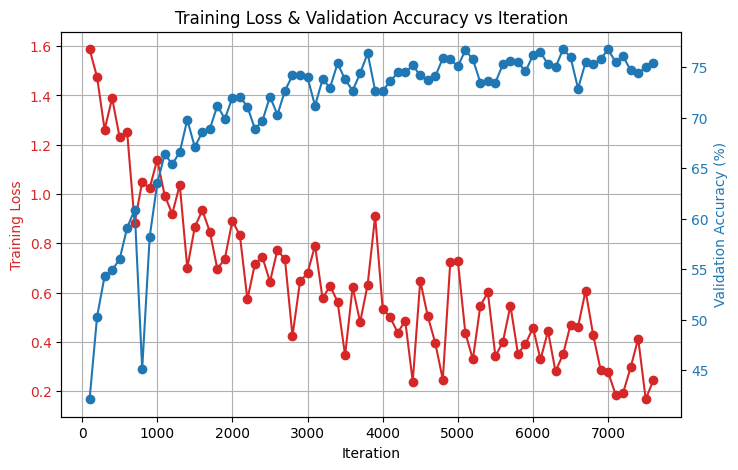

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.587515115737915,
  1.4737507104873657,
  1.2611644268035889,
  1.3887001276016235,
  1.2297980785369873,
  1.2499457597732544,
  0.8831139802932739,
  1.0496504306793213,
  1.0242490768432617,
  1.139496088027954,
  0.9932082891464233,
  0.9195818305015564,
  1.0375655889511108,
  0.6998648643493652,
  0.8659002780914307,
  0.9336367845535278,
  0.847435474395752,
  0.695

In [25]:

ResNet96_64 = ResNet(channel_1=96, channel_2=64, num_classes=10)
optimizer = optim.Adam(ResNet96_64.parameters(), lr=2e-3)

train(ResNet96_64, optimizer, epochs=10)

Epoch 1/10
[Iter 100] loss = 1.6246
   validation accuracy: 38.60%
[Iter 200] loss = 1.4075
   validation accuracy: 47.30%
[Iter 300] loss = 1.4534
   validation accuracy: 46.00%
[Iter 400] loss = 1.5238
   validation accuracy: 52.90%
[Iter 500] loss = 1.3582
   validation accuracy: 55.50%
[Iter 600] loss = 1.3286
   validation accuracy: 56.80%
[Iter 700] loss = 1.1936
   validation accuracy: 63.10%

Epoch 2/10
[Iter 800] loss = 1.3083
   validation accuracy: 47.90%
[Iter 900] loss = 0.9647
   validation accuracy: 57.30%
[Iter 1000] loss = 0.9736
   validation accuracy: 58.40%
[Iter 1100] loss = 1.2317
   validation accuracy: 61.70%
[Iter 1200] loss = 0.9381
   validation accuracy: 65.60%

⚠️ Training interrupted by user. Plotting collected results...



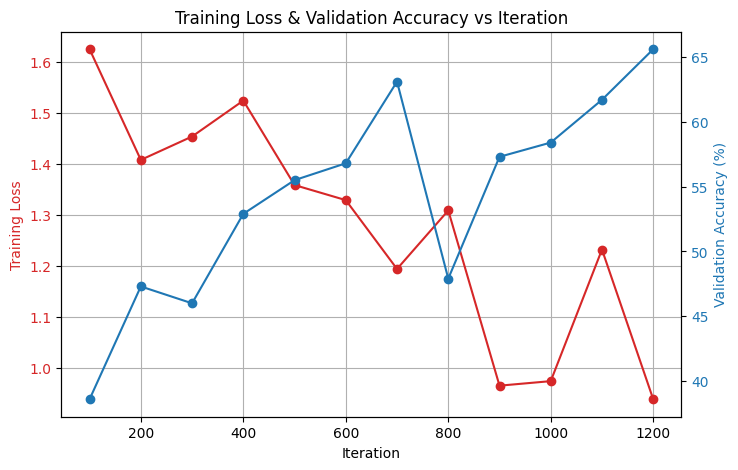

{'iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
 'train_loss': [1.6245746612548828,
  1.407480001449585,
  1.4533555507659912,
  1.5238059759140015,
  1.3581660985946655,
  1.3286101818084717,
  1.1935858726501465,
  1.3083431720733643,
  0.9646944999694824,
  0.9735826849937439,
  1.2316769361495972,
  0.9381142854690552],
 'val_acc': [0.386,
  0.473,
  0.46,
  0.529,
  0.555,
  0.568,
  0.631,
  0.479,
  0.573,
  0.584,
  0.617,
  0.656]}

In [23]:

ResNet128_96 = ResNet(channel_1=128, channel_2=96, num_classes=10)
optimizer = optim.Adam(ResNet128_96.parameters(), lr=3e-3)

train(ResNet128_96, optimizer, epochs=10)

### Model Evaluation

In [26]:
best_model = ResNet96_64
evaluate_model(loader_test, best_model)

Checking accuracy on test set
Got 7530 / 10000 correct (75.30)
